Train on 14000 samples, validate on 6000 samples
Epoch 1/20
Epoch 00001: val_acc improved from -inf to 0.83183, saving model to best_model
 - 99s - loss: 0.9225 - acc: 0.6933 - val_loss: 0.4175 - val_acc: 0.8318
Epoch 2/20
Epoch 00002: val_acc improved from 0.83183 to 0.84683, saving model to best_model
 - 93s - loss: 0.3664 - acc: 0.8566 - val_loss: 0.3732 - val_acc: 0.8468
Epoch 3/20
Epoch 00003: val_acc did not improve
 - 96s - loss: 0.2580 - acc: 0.9106 - val_loss: 0.3957 - val_acc: 0.8417
Epoch 00003: early stopping
acc: 90.95%
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 200)          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 200, 200)     1000200     

,word,count
0,this,28881
1,sound,901
2,track,372


,index,count
0,1,23170
1,2,6305
2,3,3117


,index,count,percent,cumsum
0,1,23170,0.492895,0.492895
1,2,6305,0.134126,0.627021
2,3,3117,0.066308,0.693329
3,4,2062,0.043865,0.737194
4,5,1403,0.029846,0.767040


<Container object of 50 artists>

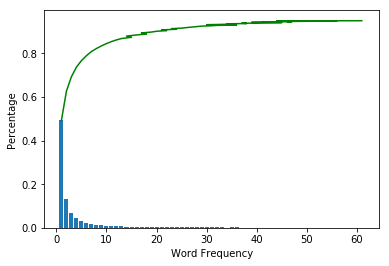

,index,counts
186,2,1
182,3,1
177,5,4


,index,counts,percent,cumsum
186,2,1,0.00005,0.00005
182,3,1,0.00005,0.00010
177,5,4,0.00020,0.00030


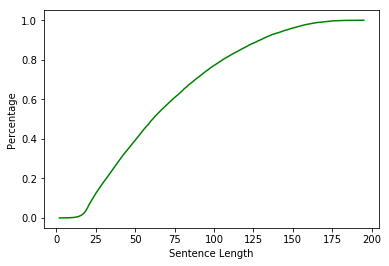

In [12]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from keras.layers import Embedding, Dense, Conv1D, MaxPooling1D, \
Dropout, Activation, Input, Flatten, Concatenate
from keras.models import Model
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
import numpy as np


              
def cnn_model(FILTER_SIZES, \
              # filter sizes as a list
              MAX_NB_WORDS, \
              # total number of words
              MAX_DOC_LEN, \
              # max words in a doc
              NUM_OUTPUT_UNITS=1, \
              # number of output units
              EMBEDDING_DIM=200, \
              # word vector dimension
              NUM_FILTERS=64, \
              # number of filters for all size
              DROP_OUT=0.5, \
              # dropout rate
              PRETRAINED_WORD_VECTOR=None,\
              # Whether to use pretrained word vectors
              LAM=0.01):            
              # regularization coefficient
    
    main_input = Input(shape=(MAX_DOC_LEN,), \
                       dtype='int32', name='main_input')
    
    if PRETRAINED_WORD_VECTOR is not None:
        embed_1 = Embedding(input_dim=MAX_NB_WORDS+1, \
                        output_dim=EMBEDDING_DIM, \
                        input_length=MAX_DOC_LEN, \
                        weights=[PRETRAINED_WORD_VECTOR],\
                        trainable=False,\
                        name='embedding')(main_input)
    else:
        embed_1 = Embedding(input_dim=MAX_NB_WORDS+1, \
                        output_dim=EMBEDDING_DIM, \
                        input_length=MAX_DOC_LEN, \
                        name='embedding')(main_input)
    # add convolution-pooling-flat block
    conv_blocks = []
    for f in FILTER_SIZES:
        conv = Conv1D(filters=NUM_FILTERS, kernel_size=f, \
                      activation='relu', name='conv_'+str(f))(embed_1)
        conv = MaxPooling1D(MAX_DOC_LEN-f+1, name='max_'+str(f))(conv)
        conv = Flatten(name='flat_'+str(f))(conv)
        conv_blocks.append(conv)

    z=Concatenate(name='concate')(conv_blocks)
    drop=Dropout(rate=DROP_OUT, name='dropout')(z)

    dense = Dense(192, activation='relu',\
                    kernel_regularizer=l2(LAM),name='dense')(drop)
    preds = Dense(NUM_OUTPUT_UNITS, activation='sigmoid', name='output')(dense)
    model = Model(inputs=main_input, outputs=preds)
    
    model.compile(loss="binary_crossentropy", \
              optimizer="adam", metrics=["accuracy"]) 
    
    return model


################## MAIN FUNCTION ##########################
MAX_NB_WORDS=5000
MAX_DOC_LEN=200
BATCH_SIZES = 64
NUM_EPOCHES = 20
# filters on bigrams, trigrams, and 4-grams
FILTER_SIZES=[2,3,4]
BEST_MODEL_FILEPATH="best_model"

data=pd.read_csv("amazon_review_large.csv",header=None)
data.columns=['label','text']

# convert the class labels into binary numbers
labels = []
for i,subdata in enumerate(data['label']):
    if subdata == 2:
        labels.append('1')
    else:
        labels.append('0')
        
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(data['text'])
voc=tokenizer.word_index    
sequences = tokenizer.texts_to_sequences(data['text'])
padded_sequences = pad_sequences(sequences, \
                                 maxlen=MAX_DOC_LEN, \
                                 padding='post', \
                                 truncating='post')

mlb = LabelBinarizer()
Y=mlb.fit_transform(labels)

# Randomly split the dataset into training (70%) and test (30%) sets
X_train, X_test, Y_train, Y_test = train_test_split(padded_sequences, Y, test_size=0.3, random_state=0)

# Create a CNN model
model=cnn_model(FILTER_SIZES, MAX_NB_WORDS, MAX_DOC_LEN)

earlyStopping=EarlyStopping(monitor='val_loss', patience=0, verbose=2, mode='min')
checkpoint = ModelCheckpoint(BEST_MODEL_FILEPATH, monitor='val_acc', \
                             verbose=2, save_best_only=True, mode='max')
    
training=model.fit(padded_sequences, labels, \
          batch_size=BATCH_SIZES, epochs=NUM_EPOCHES, \
          callbacks=[earlyStopping, checkpoint],\
          validation_split=0.3, verbose=2)

model.load_weights("best_model")

scores = model.evaluate(padded_sequences, labels, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

print model.summary()

# Performance evaluation
pred=model.predict(X_test)
Y_pred=np.copy(pred)
Y_pred=np.where(Y_pred>0.5,1,0)

Y_act=np.copy(Y_test)

print(classification_report(Y_act, Y_pred, target_names=mlb.classes_))


############### Tune hyperparameters and observe how performance changes #############

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# total number of words
total_nb_words=len(tokenizer.word_counts)
print "total_nb_words:"
print(total_nb_words)

# put word and its counts into a data frame
word_counts=pd.DataFrame(\
            tokenizer.word_counts.items(), \
            columns=['word','count'])
word_counts.head(3)

# get histogram of word counts
# after reset index, "index" column 
# is the word frequency
# "count" column gives how many words appear at 
# a specific frequency
df=word_counts['count'].value_counts().reset_index()
df.head(3)

# convert absolute counts to precentage
df['percent']=df['count']/len(tokenizer.word_counts)
# get cumulative percentage
df['cumsum']=df['percent'].cumsum()
df.head(5)

# plot the chart
# chart shows >90% words appear in less than 40 times
# if you like to include only words occur more than 40 times
# then MAX_NB_WORDS = 10% * total_nb_words
plt.bar(df["index"].iloc[0:50], df["percent"].iloc[0:50])
plt.plot(df["index"].iloc[0:50], df['cumsum'].iloc[0:50], c='green')

plt.xlabel('Word Frequency')
plt.ylabel('Percentage')
plt.show()


sen_len=pd.Series([len(item) for item in sequences])

# create histogram of sentence length
# the "index" is the sentence length
# "counts" is the count of sentences at a length
df=sen_len.value_counts().reset_index().sort_values(by='index')
df.columns=['index','counts']
df.head(3)

# sort by sentence length
# get percentage and cumulative percentage

df=df.sort_values(by='index')
df['percent']=df['counts']/len(sen_len)
df['cumsum']=df['percent'].cumsum()
df.head(3)

# From the plot, 90% sentences have length<200
# so it makes sense to set MAX_DOC_LEN=4~200 
plt.plot(df["index"], df['cumsum'], c='green')

plt.xlabel('Sentence Length')
plt.ylabel('Percentage')
plt.show()

